# Data Cleaning and Feature Engineering

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV ,cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from xgboost import XGBRegressor
import tensorflow as tf
import pickle
import string
import re
import numpy as np
import statistics
import math
import time
import datetime
import warnings

warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("../input/airbnb/train.csv", sep=",", encoding="utf-8")
test = pd.read_csv("../input/airbnb/test.csv", sep=",", encoding="utf-8")
train_review = pd.read_csv("../input/airbnb/reviews.csv", sep=",", encoding="utf-8")

In [5]:
train_new =  pd.merge(train, train_review, on="listing_id")

Inspecting the columns of both the train and the test set, we notice that both datasets have same columns except for the price variable.

In [6]:
train.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

In [7]:
test.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

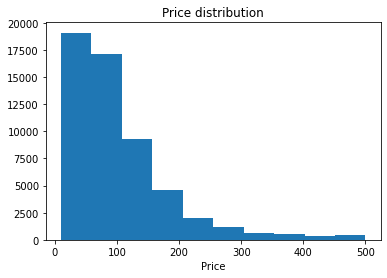

In [8]:
# Show target distribution
plt.hist(train.price)
plt.xlabel('Price')
plt.title('Price distribution')
plt.show();

We notice that the distrubution of the target variable, price of properties, is skewed towards the left. Seems like most of the properties have lower prices on Airbnb while few properties having high prices. We would not truncate the target variable since the lower prices of a property must have some reason. The analysis of Target variable distribution will be seen later. 

## Checking Duplicates in the data

In [9]:
train_duplicate = train.copy()

In [10]:
#checking duplicates in data
train_duplicate[train_duplicate.duplicated()]

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id


## Cleaning Train Dataset

In [11]:
#checking percentage of null values for all features
train.isnull().sum()/55284 * 100

name                            0.025324
summary                         5.343318
space                          30.535055
description                     3.122061
experiences_offered             0.000000
neighborhood_overview          35.283265
transit                        35.827726
house_rules                    42.287099
picture_url                     0.000000
host_id                         0.000000
host_since                      0.200781
host_response_time             32.200998
host_response_rate             32.200998
host_is_superhost               0.200781
host_total_listings_count       0.200781
host_has_profile_pic            0.200781
host_identity_verified          0.200781
neighbourhood                   0.265900
neighbourhood_cleansed          0.000000
zipcode                         2.300847
latitude                        0.000000
longitude                       0.000000
property_type                   0.000000
room_type                       0.000000
accommodates    

The boolean columns for instance 'host_is_superhost','host_has_profile_pic' and 'host_identity_verified' are converted to integer datatypes and missing values are filled with 0 in each case. The numerical variables like bathrooms,bedrooms, and beds are assumed to be ordinal similar to review_score variables, where the numerical scores exist on an arbitary numerical scale; hence we  replace the missing values for these variables with the median.'review_scores_rating' variable is assumed an exception to this rule and is replaced with mean assuming it to be continous variable.

Furthermore, we create new feature called 'host_days' from 'host_since', depicting the number of years since a property is listed on Airbnb. We also convert the host_response_rate to a continous variable. The numerical variables are scaled with mean feature value of zero with standard deviation equal to one. 

Finally, the categorical variables with fewer category levels ('host_response_time','room_type','bed_type') are handled by generating dummy variables. The ones with higher category levels ("cancellation_policy", "property_type","neighbourhood_cleansed") are handled via binning using weight of evidence(WoE) approach.Since WoE is only applicable for binary classfication, we create a binary target variable called'price_cat' from 'price'. The variables "latitude","longitude","zipcode" and neighbourhood are excluded since they provide redundant information about the location of the property present in neighbourhood_cleansed. 

The same preprocessing pipeline is followed for cleaning test dataset in the following section.

In [12]:
train['host_is_superhost'].fillna(0,inplace = True) #replacing NA with 0, assuming 0 is false value. 
train.host_is_superhost[train.host_is_superhost == "t"] = 1 #replacing "t" with 1
train.host_is_superhost[train.host_is_superhost == "f"] = 0 #replacing "f" with 0
train["host_is_superhost"] = train["host_is_superhost"].astype("int64") #converting host_is_superhost to int datatype
train['host_has_profile_pic'].fillna(0,inplace = True) #replacing NA with 0, assuming 0 is false value. 
train.host_has_profile_pic[train.host_has_profile_pic == "t"] = 1 #replacing "t" with 1
train.host_has_profile_pic[train.host_has_profile_pic == "f"] = 0 #replacing "f" with 0
train["host_has_profile_pic"] = train["host_has_profile_pic"].astype("int64") #converting host_is_superhost to int datatype

train['host_identity_verified'].fillna(0,inplace = True) #replacing NA with 0, assuming 0 is false value. 
train.host_identity_verified[train.host_identity_verified == "t"] = 1 #replacing "t" with 1
train.host_identity_verified[train.host_identity_verified == "f"] = 0 #replacing "f" with 0
train["host_identity_verified"] = train["host_identity_verified"].astype("int64") #converting host_is_superhost to int datatype

train['host_total_listings_count'].fillna(train['host_total_listings_count'].mean(),inplace = True) #replacing NA with mean of 'host_total_listings_count']
train['bathrooms'].fillna(train['bathrooms'].median(),inplace = True) #replacing NA with most frequently occuring zipcode 
train['bedrooms'].fillna(train['bedrooms'].median(),inplace = True) #replacing NA with most frequently occuring zipcode 
train['beds'].fillna(train['beds'].median(),inplace = True) #replacing NA with most frequently occuring zipcode 

train['review_scores_rating'].fillna(train['review_scores_rating'].mean(),inplace = True)
train['review_scores_accuracy'].fillna(train['review_scores_accuracy'].median(),inplace = True)
train['review_scores_cleanliness'].fillna(train['review_scores_cleanliness'].median(),inplace = True)
train['review_scores_checkin'].fillna(train['review_scores_checkin'].median(),inplace = True)
train['review_scores_communication'].fillna(train['review_scores_communication'].median(),inplace = True)
train['review_scores_location'].fillna(train['review_scores_location'].median(),inplace = True)
train['review_scores_value'].fillna(train['review_scores_value'].median(),inplace = True)
train['reviews_per_month'].fillna(train['reviews_per_month'].mean(),inplace = True)


train["property_type"] = train["property_type"].astype("category") #convert to woe
train["cancellation_policy"] = train["cancellation_policy"].astype("category") #convert to woe
train["room_type"] = train["room_type"].astype("category") 
train["bed_type"] = train["bed_type"].astype("category") 
train['host_response_time'].fillna("missing",inplace = True)
train["host_response_time"] = train["host_response_time"].astype("category") 


train["host_since"] = train["host_since"].astype("datetime64[ns]")
train["host_since"].fillna(pd.to_datetime('2015-05-21'),inplace = True)
train['host_days'] = (datetime.datetime.today() - train['host_since'])//np.timedelta64(1,'D')   
train['host_days'] = train['host_days']/365

train['host_response_rate_num'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
train['host_response_rate_num'].fillna(0,inplace=True)

x_train_dummies = pd.get_dummies(train, columns = ['host_response_time','room_type','bed_type'], drop_first=True)          

In [13]:
!pip install scorecardpy
import scorecardpy as sc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57843 sha256=ddc897ac231ec62678d4145d1c2d2448896c571f8ae6717575616d517637d589
  Stored in directory: /root/.cache/pip/wheels/9d/50/52/715367c478fd2e2317070ccf6539b2c29fc8168144cfbfaeac
Successfully built scorecardpy


In [14]:
x_train_dummies.drop(["host_id","latitude","longitude","zipcode"], inplace=True, axis=1)
X_train = x_train_dummies.drop(['price'], axis=1) 
y_train = x_train_dummies[['price']]

In [15]:
num_cols=X_train.select_dtypes(include=["int64","float64"]).columns
num_cols

Index(['host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'host_days',
       'host_response_rate_num'],
      dtype='object')

In [16]:
standard = StandardScaler()

X_train[num_cols] = standard.fit_transform(X_train[num_cols])

In [17]:
train_df = pd.concat([X_train, y_train], axis=1, join="inner")
train_df['price_cat'] = pd.cut(train_df.price,bins=[0,200,500],labels=[0,1])
train_df['price_cat'] = train_df.price_cat.astype('bool')

In [18]:
bins_regression = sc.woebin(train_df, y="price_cat", x=["cancellation_policy", "property_type","neighbourhood_cleansed"])

[INFO] creating woe binning ...


In [19]:
X_train_woe = sc.woebin_ply(X_train, bins_regression)

[INFO] converting into woe values ...


In [20]:
train_df = pd.concat([X_train_woe, y_train], axis=1, join="inner")

In [21]:
train_df.to_pickle('x_train.pkl')

## Cleaning Test Dataset

In [75]:
test['host_is_superhost'].fillna(0,inplace = True) #replacing NA with 0, assuming 0 is false value. 
test.host_is_superhost[test.host_is_superhost == "t"] = 1 #replacing "t" with 1
test.host_is_superhost[test.host_is_superhost == "f"] = 0 #replacing "f" with 0
test["host_is_superhost"] = test["host_is_superhost"].astype("int64") #converting host_is_superhost to boolean datatype
test['host_has_profile_pic'].fillna(0,inplace = True) #replacing NA with 0, assuming 0 is false value. 
test.host_has_profile_pic[test.host_has_profile_pic == "t"] = 1 #replacing "t" with 1
test.host_has_profile_pic[test.host_has_profile_pic == "f"] = 0 #replacing "f" with 0
test["host_has_profile_pic"] = test["host_has_profile_pic"].astype("int64") #converting host_is_superhost to boolean datatype

test['host_identity_verified'].fillna(0,inplace = True) #replacing NA with 0, assuming 0 is false value. 
test.host_identity_verified[test.host_identity_verified == "t"] = 1 #replacing "t" with 1
test.host_identity_verified[test.host_identity_verified == "f"] = 0 #replacing "f" with 0
test["host_identity_verified"] = test["host_identity_verified"].astype("int64") #converting host_is_superhost to boolean datatype

test['host_total_listings_count'].fillna(test['host_total_listings_count'].mean(),inplace = True) #replacing NA with mean of 'host_total_listings_count']
test['bathrooms'].fillna(test['bathrooms'].median(),inplace = True) #replacing NA with most frequently occuring zipcode 
test['bedrooms'].fillna(test['bedrooms'].median(),inplace = True) #replacing NA with most frequently occuring zipcode 
test['beds'].fillna(test['beds'].median(),inplace = True) #replacing NA with most frequently occuring zipcode 

test['review_scores_rating'].fillna(test['review_scores_rating'].mean(),inplace = True)
test['review_scores_accuracy'].fillna(test['review_scores_accuracy'].median(),inplace = True)
test['review_scores_cleanliness'].fillna(test['review_scores_cleanliness'].median(),inplace = True)
test['review_scores_checkin'].fillna(test['review_scores_checkin'].median(),inplace = True)
test['review_scores_communication'].fillna(test['review_scores_communication'].median(),inplace = True)
test['review_scores_location'].fillna(test['review_scores_location'].median(),inplace = True)
test['review_scores_value'].fillna(test['review_scores_value'].median(),inplace = True)
test['reviews_per_month'].fillna(test['reviews_per_month'].mean(),inplace = True)


test["property_type"] = test["property_type"].astype("category") #convert to woe
test["cancellation_policy"] = test["cancellation_policy"].astype("category") #convert to woe
test["room_type"] = test["room_type"].astype("category") 
test["bed_type"] = test["bed_type"].astype("category") 
test['host_response_time'].fillna("missing",inplace = True)
test["host_response_time"] = test["host_response_time"].astype("category") 


test["host_since"] = test["host_since"].astype("datetime64[ns]")
test["host_since"].fillna(pd.to_datetime('2015-05-21'),inplace = True)
test['host_days'] = (datetime.datetime.today() - test['host_since'])//np.timedelta64(1,'D')   
test['host_days'] = test['host_days']/365

test['host_response_rate_num'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test['host_response_rate_num'].fillna(0,inplace=True)

x_test_dummies = pd.get_dummies(test, columns = ['host_response_time','room_type','bed_type'], drop_first=True)          

In [76]:
x_test_dummies.drop(["host_id","latitude","longitude","zipcode"], inplace=True, axis=1)

In [77]:
num_cols=x_test_dummies.select_dtypes(include=["int64","float64"]).columns
num_cols

Index(['host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'host_days',
       'host_response_rate_num'],
      dtype='object')

In [78]:
standard = StandardScaler()

x_test_dummies[num_cols] = standard.fit_transform(x_test_dummies[num_cols])

In [79]:
X_test_woe = sc.woebin_ply(x_test_dummies, bins_regression)

[INFO] converting into woe values ...


In [80]:
X_test_woe.to_pickle('x_test.pkl')

# Feature Selection

In [43]:
train_df = pd.read_pickle('../input/numerical-data-cleaned-airbnb-final/x_train (1).pkl')
X_test_woe = pd.read_pickle('../input/numerical-data-cleaned-airbnb-final/x_test (1).pkl')

In [25]:
train_num_cols = train_df.select_dtypes(exclude=["category","datetime64[ns]","object"])
test_num_cols = X_test_woe.select_dtypes(exclude=["category","datetime64[ns]","object"])

In [26]:

test_num_cols.isnull().sum()

host_is_superhost                        0
reviews_per_month                        0
room_type_Private room                   0
bed_type_Real Bed                        0
bed_type_Pull-out Sofa                   0
bedrooms                                 0
bed_type_Couch                           0
beds                                     0
room_type_Shared room                    0
review_scores_location                   0
guests_included                          0
bed_type_Futon                           0
review_scores_rating                     0
host_identity_verified                   0
host_has_profile_pic                     0
review_scores_accuracy                   0
host_response_time_within a day          0
review_scores_cleanliness                0
host_response_time_within an hour        0
review_scores_value                      0
host_total_listings_count                0
review_scores_checkin                    0
host_days                                0
host_respon

In [27]:
test_num_cols['property_type_woe'].fillna(0,inplace=True)

In [28]:
# Extract target variable and feature matrix 
X = train_num_cols.drop(['price'], axis=1) 
y = train_num_cols[['price']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=888)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44227 entries, 25103 to 10750
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_is_superhost                      44227 non-null  float64
 1   reviews_per_month                      44227 non-null  float64
 2   room_type_Private room                 44227 non-null  uint8  
 3   bed_type_Real Bed                      44227 non-null  uint8  
 4   bed_type_Pull-out Sofa                 44227 non-null  uint8  
 5   bedrooms                               44227 non-null  float64
 6   bed_type_Couch                         44227 non-null  uint8  
 7   beds                                   44227 non-null  float64
 8   room_type_Shared room                  44227 non-null  uint8  
 9   review_scores_location                 44227 non-null  float64
 10  guests_included                        44227 non-null  float64
 11

In [34]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [35]:
clf = LinearRegression()
sfs = SFS(clf, 
           k_features="best", 
           forward=True, 
           floating=False, 
           scoring='neg_mean_squared_error',
           cv=3,
         verbose = 1)

sfs = sfs.fit(X_train, np.ravel(y_train.values))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.3s finished
Features: 1/33[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.1s finished
Features: 2/33[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    1.5s finished
Features: 3/33[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.2s finished
Features: 4/33[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.3s finished
Features: 5/33[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.8s finished
Features: 6/33[Parallel(

In [36]:
print('best combination (neg_mean_squared_error: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))

best combination (neg_mean_squared_error: -3156.780): ('host_is_superhost', 'reviews_per_month', 'room_type_Private room', 'bed_type_Real Bed', 'bed_type_Pull-out Sofa', 'bedrooms', 'beds', 'room_type_Shared room', 'review_scores_location', 'guests_included', 'bed_type_Futon', 'review_scores_rating', 'host_identity_verified', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_value', 'host_total_listings_count', 'review_scores_checkin', 'host_days', 'host_response_time_missing', 'host_response_rate_num', 'accommodates', 'host_response_time_within a few hours', 'room_type_Hotel room', 'bathrooms', 'cancellation_policy_woe', 'property_type_woe', 'neighbourhood_cleansed_woe')



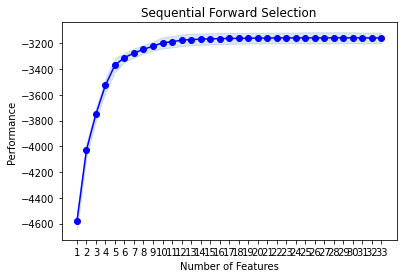

In [37]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')

plt.show()

In [38]:
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_val)

clf.fit(X_train_sfs, np.ravel(y_train.values))
y_pred = clf.predict(X_test_sfs)

In [17]:
X_train_sfs

array([[-0.89300457, -0.2194665 ,  0.        , ...,  1.        ,
         0.09550594,  0.45427853],
       [-0.89300457, -0.2194665 ,  0.        , ...,  1.        ,
         0.09550594, -0.0821131 ],
       [-2.25973024, -1.32366979,  0.        , ...,  1.        ,
        -0.4056011 , -0.0821131 ],
       ...,
       [ 0.4737211 , -0.2194665 ,  0.        , ...,  1.        ,
         0.09550594,  0.45427853],
       [ 0.4737211 , -0.2194665 ,  1.        , ...,  1.        ,
        -0.4056011 , -0.0821131 ],
       [ 0.4737211 ,  0.88473679,  0.        , ...,  1.        ,
         0.09550594, -0.0821131 ]])

In [39]:
print(f"MSE: {mean_squared_error(y_val, y_pred)}")
print(f"MAE: {mean_absolute_error(y_val, y_pred)}")

MSE: 3197.3792662772494
MAE: 35.75327164441176


In [43]:
preds_kaggle = clf.predict(test_num_cols[['host_is_superhost', 'reviews_per_month', 'room_type_Private room', 'bed_type_Real Bed', 'bed_type_Pull-out Sofa', 'bedrooms', 'beds', 'room_type_Shared room', 'review_scores_location', 'guests_included', 'bed_type_Futon', 'review_scores_rating', 'host_identity_verified', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_value', 'host_total_listings_count', 'review_scores_checkin', 'host_days', 'host_response_time_missing', 'host_response_rate_num', 'accommodates', 'host_response_time_within a few hours', 'room_type_Hotel room', 'bathrooms', 'cancellation_policy_woe', 'property_type_woe', 'neighbourhood_cleansed_woe']])

In [44]:
from sklearn.feature_selection import RFECV

In [45]:
clf = LinearRegression()

rfecv = RFECV(estimator=clf, step=1, cv=2, scoring='neg_mean_squared_error')
X_train_new = rfecv.fit(X_train,  np.ravel(y_train.values))

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 33


In [46]:
X_train.columns[rfecv.support_]

Index(['host_is_superhost', 'reviews_per_month', 'room_type_Private room',
       'bed_type_Real Bed', 'bed_type_Pull-out Sofa', 'bedrooms',
       'bed_type_Couch', 'beds', 'room_type_Shared room',
       'review_scores_location', 'guests_included', 'bed_type_Futon',
       'review_scores_rating', 'host_identity_verified',
       'host_has_profile_pic', 'review_scores_accuracy',
       'host_response_time_within a day', 'review_scores_cleanliness',
       'host_response_time_within an hour', 'review_scores_value',
       'host_total_listings_count', 'review_scores_checkin', 'host_days',
       'host_response_time_missing', 'host_response_rate_num',
       'review_scores_communication', 'accommodates',
       'host_response_time_within a few hours', 'room_type_Hotel room',
       'bathrooms', 'cancellation_policy_woe', 'property_type_woe',
       'neighbourhood_cleansed_woe'],
      dtype='object')

The  Feature selection using both backward and forward stepwise regression doesn't result in the improvement of performance. Hence, the results from feature selection are not taken into account going forward.

**Note: Please use the x_train.pkl and x_test.pickle files obtained from this notebook for running the code in the main notebook i.e. w2v pretrained modeling airbnb.ipnyb and auxillary notebook- Self_trained_emb_modeling_airbnb.ipnyb.**